In [44]:
import datetime
import lightgbm
import numpy as np
import pandas as pd
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

##### Defining features with respect to their types

* From our EDA phase we found that the feature *unit_discount_weekly* has negligible correlation with the sales of the product. So we will drop it from our list of features.
* We will drop the duplicate columns of *hierarchy_level2_id* and *hierarchy_level3_desc*.

In [2]:
CATEGORICAL_FEATURES = [
    "hierarchy_level2_desc",
    "hierarchy_level3_desc", 
]
NUMERICAL_FEATURES = [
    "store_count",
    "total_cust_count",
    "unit_price_weekly",
    #"unit_discount_weekly"
]
TEXT_FEATURES = "art_name"

FLAG_FEATURES = [
    "low_stock_warning"
]

TARGET = "sold_qty_units"


In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

##### Inverse Distance Weighting
* *sample_weight* to the lightgbm model helps to add more importance to the most recent obsevations. 
* Rasing weight to the positive power helps to increase importance of the most recent data.

In [4]:
def estimate_sample_weights(df, n):
    return ((df.date_of_day - df.date_of_day.min()).dt.days + 1) ** n

##### Pipeline Definition
* OneHotEncoder() - Encodes the *low_stock_warning* as it is a boolean datatype.
* OrdinalEncoder() - Product subcategories *hierarchy_level2_desc* and *hierarchy_level3_desc* 
* We will pass through the numerical features without any transformation as at each tree level, the score of a possible split will be equal irrespective of the feature being scaled or not.
* TfidfVectorizer() - Reason for encoding the *art_name* using tfidf:
  > https://www.shopify.com/blog/8211159-9-simple-ways-to-write-product-descriptions-that-sell
  
     A product description can’t really make an impact on sales, right? 
Wrong. In fact, evidence from an ecommerce study conducted by Nielsen Norman Group shows that 20% of unsuccessful purchases are due to lack of product information. 

##### Model - LightGBM

In [39]:
model = Pipeline([
    ("feature_preprocessor", ColumnTransformer([
        
        ("one_hot", OneHotEncoder(), FLAG_FEATURES),

        ("categorical", OrdinalEncoder(handle_missing="return_nan"), CATEGORICAL_FEATURES),

        ("numerical", "passthrough", NUMERICAL_FEATURES),

        ("text", TfidfVectorizer(), TEXT_FEATURES),
        
    ])),
    
    ("regressor", lightgbm.LGBMRegressor(
        n_estimators=3000,
        objective="regression",
        num_leaves=50,
        max_depth=10,
        min_child_samples=60,
        learning_rate=0.09,
        colsample_bytree=0.6,
        verbosity=-1,
        extra_trees=True,
        metric="mape"
    )),
])

In [40]:
data_sales = pd.read_csv('../data/take_home_final_data.csv')
data_sales['date_of_day'] = pd.to_datetime(data_sales['date_of_day'], format = "%Y-%m-%d")
data_sales.tail(5)

,art_no,art_name,hierarchy_level1_id,hierarchy_level1_desc,hierarchy_level2_id,hierarchy_level2_desc,hierarchy_level3_id,hierarchy_level3_desc,date_of_day,store_count,sold_qty_units,total_cust_count,low_stock_warning,unit_price_weekly,unit_discount_weekly
2614,22,500g Pasta Rigate,100,Processed_Food,2,Extras,1,Dough,2020-02-20,35,261.0,187,0,2.92,-0.07
2615,22,500g Pasta Rigate,100,Processed_Food,2,Extras,1,Dough,2020-10-08,34,230.0,166,0,2.95,-0.04
2616,22,500g Pasta Rigate,100,Processed_Food,2,Extras,1,Dough,2020-12-17,37,918.0,706,0,2.98,-0.01
2617,22,500g Pasta Rigate,100,Processed_Food,2,Extras,1,Dough,2019-09-26,31,157.0,120,0,2.76,-0.03
2618,22,500g Pasta Rigate,100,Processed_Food,2,Extras,1,Dough,2019-10-03,26,114.0,87,0,2.79,-0.00


##### Training and Validation split
* Training data - From *2019-02-28* to *2021-02-04* i.e 101 weeks
* Validation data - From *2021-02-11* to *2021-02-25* i.e 3 weeks 

In [41]:
date_start = data_sales.date_of_day.max() - datetime.timedelta(21)

df_train = data_sales[data_sales.date_of_day <= date_start]
df_validation = data_sales[data_sales.date_of_day > date_start]

print(df_train.shape)
print(df_validation.shape)

(2544, 15)
(75, 15)


##### Performance Metric
* We will use MAE (Mean Absolute Error) as the performance metric because of the presence of outliers in the sales of products. As the definition says MAE is the absolute difference between the actual value and predicted value it is more robust to the effects of outliers.
 
* The definition of R-squared is fairly straight-forward it is the percentage of the response variable variation that is explained by a model.

  R-squared = Explained variation / Total variation

  R-squared is always between 0 and 100%:

  0% indicates that the model explains none of the variability of the response data around its mean.
  100% indicates that the model explains all the variability of the response data around its mean.
  In general the higher the R-squared, the better the model fits our data.

##### Baseline 
An important goal in retail is to be able to forecast article demand as this enables us to plan our business. This can be done using a basic model that considers the average demand over some weeks in the past.

In [42]:
mean_absolute_error(df_validation.sold_qty_units, 
                    [df_validation["sold_qty_units"].rolling(10).mean().iloc[-1]] * len(df_validation))

168.04400000000004

In [48]:
model.fit(df_train, df_train.sold_qty_units, regressor__sample_weight=estimate_sample_weights(df_train, 5))
dump(model, '../model/model')
y_train = np.clip(model.predict(df_train), 0, np.inf).astype(int)
r2 = r2_score(df_train.sold_qty_units, y_train)
print('r2 score for the model fit', round(r2, 2))

r2 score for the model fit 0.81


In [49]:
y_predicted = np.clip(model.predict(df_validation), 0, np.inf).astype(int)
error_mae = round(mean_absolute_error(df_validation.sold_qty_units, y_predicted), 2)
error_rmse = round(rmse(df_validation.sold_qty_units, y_predicted), 2)
r2 = r2_score(df_validation.sold_qty_units, y_predicted)
print('MAE of the model trained = ', error_mae)
print('RMSE of the model trained = ', error_rmse)
print('r2 score for model prediction', round(r2, 2))

MAE of the model trained =  22.83
RMSE of the model trained =  60.95
r2 score for model prediction 0.93


In [37]:
df_test_results = pd.DataFrame({
    "art_no": df_validation.art_no,
    "date_of_day": df_validation.date_of_day,
    "sold_qty_units": y_predicted,
})

##### Prediction vs Actual Data Plot
From the graph below we can observe that the red line indicates the predicted samples and the blue indicates the actual data. It can be seemingly observed that the predicted values are closely aligned with actual data indicating the efficiency of the model in forecasting the sales of the product.

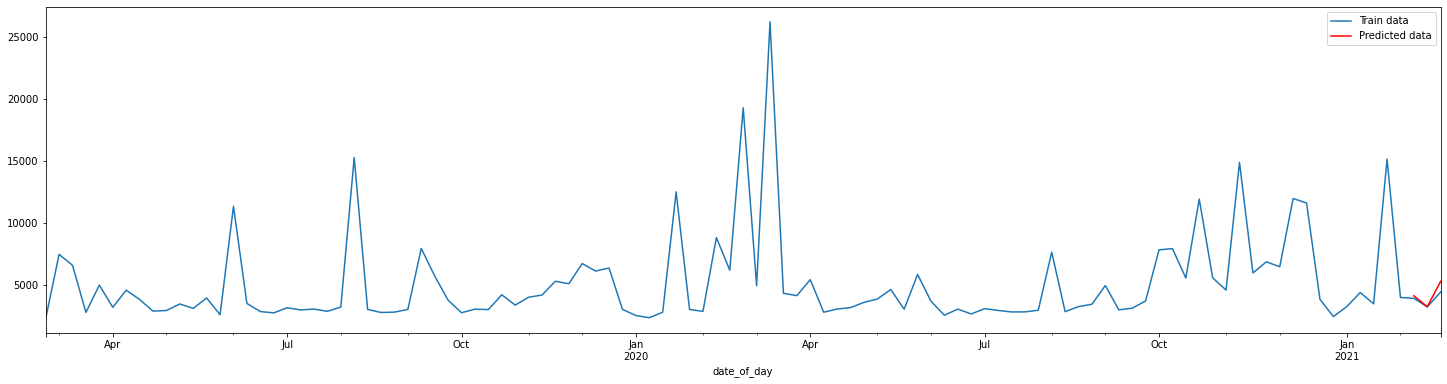

In [38]:
plt.figure(figsize=(25,6))
axis = data_sales.groupby(["date_of_day"]).sold_qty_units.sum().plot()
df_test_results.groupby(["date_of_day"]).sold_qty_units.sum().plot(ax=axis, color="red")
plt.legend(['Train data', 'Predicted data'])